# Ensambles | Desafío 1 (SDM)

**Objetivo:** aplicar ensambles (RF, GB, Stacking) a un problema de clasificación y comparar métricas.

**Reproducibilidad:** ejecuta este notebook dentro de la estructura del repo (`notebooks/`), con `requirements.txt` instalado.


In [ ]:
# === Configuración general del experimento ===
PROJECT = "Ensambles | Desafío 1"
SEED = 42
TEST_SIZE = 0.2  # fracción para test
CV = 5           # folds de validación cruzada
TARGET = "Churn"  # Ajusta si tu columna objetivo tiene otro nombre

import numpy as np
np.random.seed(SEED)


In [ ]:
# === Imports base ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# sklearn métricas y utilidades comunes
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, accuracy_score, precision_recall_fscore_support,
)

sns.set(context="notebook", style="whitegrid")


In [ ]:
# === Utilidades de exportación seguras ===
import os
REPORTS_DIR = Path("../reports")
FIG_DIR = REPORTS_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def safe_savefig(fig, path):
    try:
        fig.savefig(path, bbox_inches="tight")
        print(f"[OK] Figura guardada en {path}")
    except Exception as e:
        print(f"[WARN] No se pudo guardar figura en {path}: {e}")

def safe_to_csv(df, path, index=False):
    try:
        df.to_csv(path, index=index)
        print(f"[OK] CSV guardado en {path}")
    except Exception as e:
        print(f"[WARN] No se pudo guardar CSV en {path}: {e}")


---

# Desafío - Modelos de ensamble (parte I)(G93)

---

Este framework sigue un enfoque iterativo, aunque el trabajo se presenta de manera lineal.

En la práctica, es común regresar a etapas anteriores para realizar ajustes y optimizar el proceso.

Por ejemplo, puede ser necesario transformar variables antes de analizar correlaciones o generar visualizaciones significativas.

Este enfoque flexible permite garantizar que cada paso contribuya de manera efectiva a la construcción de un modelo preciso y robusto.

---

Nombre: SERGIO C. DELGADO MARTINEZ

Profesor: GABRIEL A. CESPEDES ALARCON

Desafio: Detección temprana de renuncias en
empresa de telecomunicaciones

Curso: Modelos avanzados y Redes Neuronales (G93)


## **Resumen Ejecutivo**

El desafío propone construir y analizar distintos modelos de ensamble para la **detección temprana de renuncias de clientes** en una empresa de telecomunicaciones. Se trabaja con un dataset que contiene variables relacionadas con el comportamiento y los servicios de los clientes. El objetivo es predecir el abandono (churn) y explicar qué factores influyen más en esa decisión.


---

## **Contenido del Dataset (`telecom_churn.csv`)**

| Variable          | Descripción                                     |
|------------------|-------------------------------------------------|
| `Churn`          | Variable objetivo (1 = renuncia, 0 = permanece) |
| `AccountWeeks`   | Semanas con la cuenta activa                    |
| `ContractRenewal`| Si renovó contrato recientemente (1/0)          |
| `DataPlan`       | Si tiene plan de datos (1/0)                    |
| `DataUsage`      | Uso mensual de datos (GB)                       |
| `CustServCalls`  | Nº de llamadas al servicio al cliente           |
| `DayMins`        | Promedio de minutos diurnos al mes              |
| `DayCalls`       | Nº medio de llamadas diurnas                    |
| `MonthlyCharge`  | Cargo mensual promedio                          |
| `OverageFee`     | Máximo recargo por exceso en últimos 12 meses   |
| `RoamMin`        | Minutos de uso en roaming                       |

---

## Tareas Específicas

---

### 1. Exploración de Datos (EDA)

- Importación de librerías estándar para análisis, visualización y modelado.
- Carga del dataset y verificación de estructura, tipos de datos, valores nulos y duplicados.
- Análisis descriptivo de variables numéricas.
- Evaluación del **desbalance de la variable objetivo (Churn)**.
- Visualización de distribuciones y relaciones entre variables:
  - Pair plots por clase.
  - Boxplots comparativos por churn.
- Análisis de correlaciones mediante **heatmap**, identificando colinealidad y señales relevantes.
- Identificación de variables clave desde una perspectiva técnica y de negocio.

---

### 2. Árbol de Decisión

- Entrenamiento de un **árbol de decisión base** sin ajuste de hiperparámetros.
- Evaluación de desempeño en train y test:
  - Accuracy, precision, recall y f1-score.
  - Matriz de confusión.
- Optimización mediante **GridSearchCV (5-fold, estratificado)** para:
  - `max_depth`
  - `min_samples_split`
- Comparación entre modelo base y optimizado, destacando:
  - Riesgo de sobreajuste.
  - Limitaciones del árbol como modelo único para churn.

---

### 3. Bagging Homogéneo con SMOTE

- Aplicación de **SMOTE exclusivamente sobre el conjunto de entrenamiento** para balancear clases.
- Entrenamiento de un modelo de **Bagging homogéneo** con:
  - Árboles de decisión como estimadores base.
  - **200 estimadores**.
- Evaluación del desempeño en test, con foco en:
  - Recall y f1-score de la clase churn.
- Análisis del trade-off entre detección temprana y aumento de falsos positivos.

---

### 4. Bagging Heterogéneo

- Construcción de un ensamble heterogéneo utilizando:
  - Regresión Logística (con escalado).
  - Árbol de Decisión.
  - SVM con kernel RBF (con escalado).
  - SVM con kernel Sigmoid (con escalado).
- Uso de **200 muestras bootstrap (T = 200)**.
- Implementación mediante la función **`bagging_het`** del archivo `util_bagging.py`.
- Evaluación inicial del ensamble sin calibración.
- **Calibración de importancia**:
  - Selección del mejor modelo base según **F1 promedio en validación cruzada (5-fold)**.
  - Repetición explícita de dicho modelo dentro del ensamble.
- Evaluación final en test y comparación con otras estrategias de bagging.

---

### 5. Random Forest Básico

- Entrenamiento de un **Random Forest** con:
  - `n_estimators = 45`.
  - Cálculo de **OOB accuracy** como estimación interna de generalización.
- Evaluación de desempeño en test con métricas foco churn.
- Identificación de las **4 variables más importantes**, contrastando con el análisis exploratorio.
- Análisis del Random Forest como baseline robusto y explicable.

---

### 6. Random Forest Optimizado con GridSearch

- Optimización de hiperparámetros mediante **GridSearchCV (5-fold estratificado)**:
  - `n_estimators`: 50 a 200 (paso de 10).
  - `max_features`: `sqrt`, `log2`, `None`.
- Selección del modelo final en función de **F1-score (churn)**.
- Reporte de:
  - Mejores hiperparámetros.
  - **OOB accuracy** del modelo optimizado.
  - Importancia de atributos.
- Evaluación completa en test:
  - Precision, recall, f1-score (clase churn).
  - Balanced accuracy.
  - **Curva ROC y ROC-AUC**.
- Comparación con todos los modelos previos del notebook.

---

### 7. Clientes con Mayor Riesgo de Renuncia

- Uso del **Random Forest optimizado** como modelo final.
- Predicción de probabilidades de churn.
- Identificación y listado de los **15 clientes con mayor probabilidad estimada de renuncia**.
- Análisis cualitativo de patrones comunes en clientes de alto riesgo.
- Discusión de **implicancias de negocio** y posibles acciones de retención.

---


## **Tareas Específicas**

### 1. **Exploración de Datos**
- Importar librerías
- Cargar datos
- Visualizar variables
- Analizar correlaciones (usar heatmap)

### 2. **Árbol de Decisión**
- Entrenar árbol sin ajustar hiperparámetros
- Evaluar métricas
- Optimizar con Grid Search (5-fold CV) para `max_depth` y `min_samples_split`
- Reportar hiperparámetros óptimos y desempeño (train/test)

### 3. **Bagging con SMOTE**
- Aplicar SMOTE al set de entrenamiento para balancear clases
- Entrenar modelo de Bagging con 200 estimadores (homogéneo)
- Evaluar desempeño en set de test

### 4. **Bagging Heterogéneo**
- Entrenar modelo con:
  - Regresión Logística
  - Árbol de decisión
  - SVM (kernel RBF)
  - SVM (kernel Sigmoid)
- Usar 200 muestras bootstrap
- Evaluar f1-score y repetir el mejor modelo para calibrar importancia
- Utilizar `bagging_het` del archivo `util_bagging.py`
- Reportar métricas finales en test

### 5. **Random Forest Básico**
- Usar `n_estimators = 45`
- Evaluar OOB accuracy
- Identificar 4 características más importantes
- Evaluar desempeño en test

### 6. **Random Forest con Grid Search**
- Hiperparámetros a buscar:
  - `n_estimators`: 50 a 200 (paso de 10, total 15 valores)
  - `max_features`: [`sqrt`, `log2`, `None`]
- Reportar:
  - Mejores hiperparámetros
  - OOB accuracy
  - Importancia de atributos
  - Análisis de métricas, curva ROC y AUC

### 7. **Clientes con Mayor Riesgo de Renuncia**
- Con el modelo final optimizado de Random Forest:
  - Identificar y mostrar los **15 clientes con mayor probabilidad de renunciar**

---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB

Dimensión del dataset (filas, columnas): (3333, 11)

Muestra aleatoria de registros:


,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
438,0,113,1,0,0.00,1,155.0,93,55.0,16.53,13.5
2674,0,67,1,0,0.00,0,109.1,117,38.0,10.87,12.8
1345,1,98,1,0,0.00,4,0.0,0,14.0,7.98,6.8
1957,0,147,1,0,0.33,1,212.8,79,57.3,10.21,10.2
2148,0,96,1,0,0.30,1,144.0,102,47.0,11.24,10.0



Duplicados detectados: 0

Valores nulos por columna (top 15):
Churn              0
AccountWeeks       0
ContractRenewal    0
DataPlan           0
DataUsage          0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee         0
RoamMins           0

Estadísticas descriptivas (numéricas):


,count,mean,std,min,25%,50%,75%,max
Churn,3333.0,0.144914,0.352067,0.0,0.00,0.00,0.00,1.00
AccountWeeks,3333.0,101.064806,39.822106,1.0,74.00,101.00,127.00,243.00
ContractRenewal,3333.0,0.903090,0.295879,0.0,1.00,1.00,1.00,1.00
DataPlan,3333.0,0.276628,0.447398,0.0,0.00,0.00,1.00,1.00
DataUsage,3333.0,0.816475,1.272668,0.0,0.00,0.00,1.78,5.40
CustServCalls,3333.0,1.562856,1.315491,0.0,1.00,1.00,2.00,9.00
DayMins,3333.0,179.775098,54.467389,0.0,143.70,179.40,216.40,350.80
DayCalls,3333.0,100.435644,20.069084,0.0,87.00,101.00,114.00,165.00
MonthlyCharge,3333.0,56.305161,16.426032,14.0,45.00,53.50,66.20,111.30
OverageFee,3333.0,10.051488,2.535712,0.0,8.33,10.07,11.77,18.19



Distribución de la variable 'Churn':
       count  proportion
Churn                   
0       2850       0.855
1        483       0.145


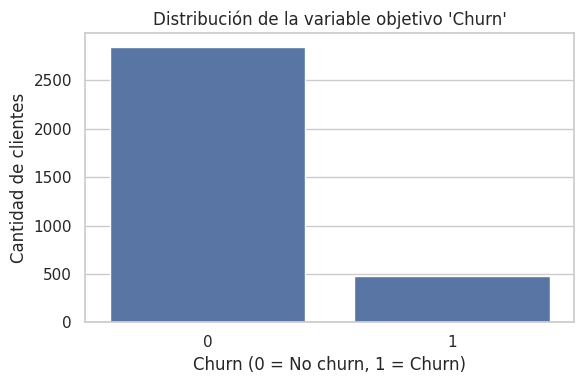


Columnas numéricas: 10 | Columnas categóricas/bool: 0


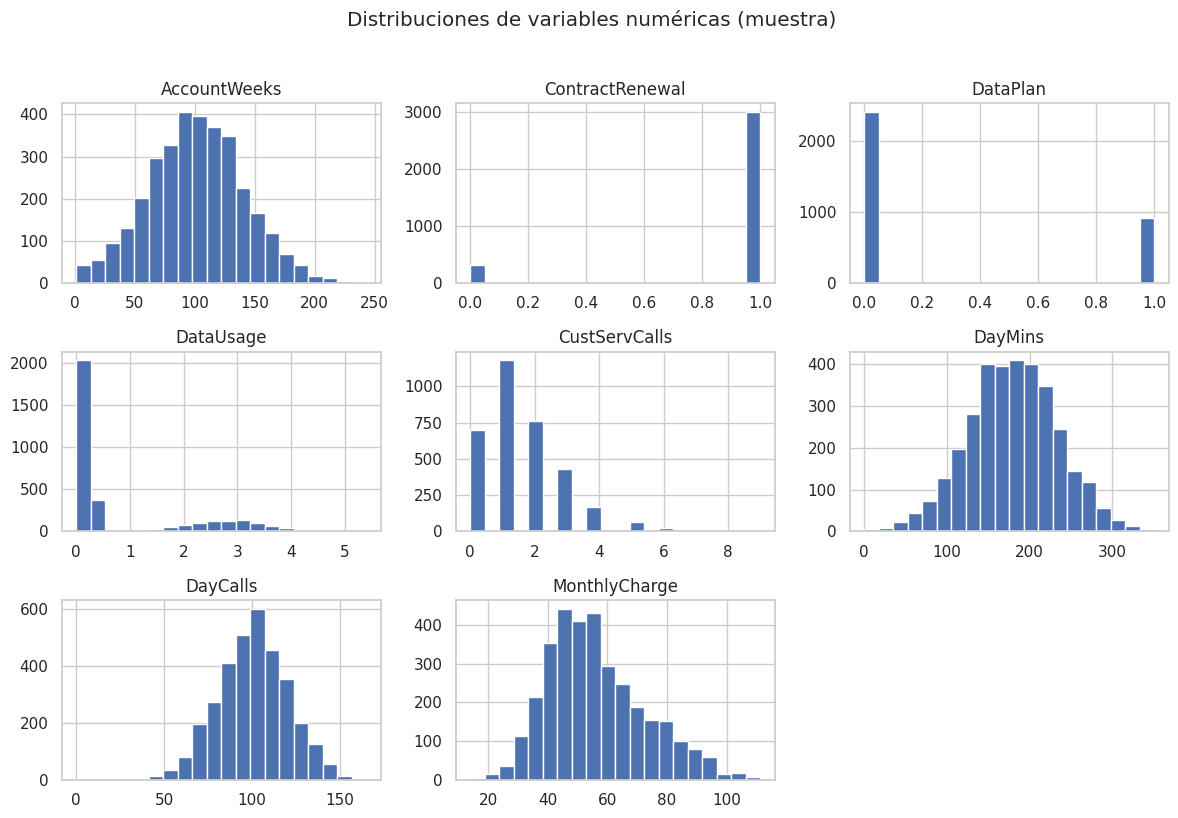

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import warnings

# Recomendación: no silenciar TODO. Filtra solo warnings comunes y no críticos.
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# =========================
# 1) Carga de datos
# =========================
DATA_DIR = Path("/content/")
FILE_NAME = "telecom_churn.csv"
TARGET = "Churn"

df = pd.read_csv(DATA_DIR / FILE_NAME)

print("Información general del dataset:")
df.info()

print("\nDimensión del dataset (filas, columnas):", df.shape)

print("\nMuestra aleatoria de registros:")
try:
    display(df.sample(5, random_state=42))
except NameError:
    print(df.sample(5, random_state=42).to_string(index=False))

# =========================
# 2) Calidad de datos básica
# =========================
dup_count = df.duplicated().sum()
print(f"\nDuplicados detectados: {dup_count}")
if dup_count > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"Duplicados eliminados. Total de registros: {df.shape[0]}")

print("\nValores nulos por columna (top 15):")
nulls = df.isnull().sum().sort_values(ascending=False)
print(nulls.head(15).to_string())

print("\nEstadísticas descriptivas (numéricas):")
try:
    display(df.describe(include=[np.number]).T)
except NameError:
    print(df.describe(include=[np.number]).T.to_string())

# =========================
# 3) Variable objetivo (balance)
# =========================
if TARGET not in df.columns:
    raise ValueError(f"No se encontró la columna objetivo '{TARGET}' en el dataset.")

print(f"\nDistribución de la variable '{TARGET}':")
vc = df[TARGET].value_counts(dropna=False)
vcp = df[TARGET].value_counts(normalize=True, dropna=False).round(3)
print(pd.DataFrame({"count": vc, "proportion": vcp}).to_string())

sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=TARGET, data=df)  # sin palette para evitar warnings de versiones
ax.set_title(f"Distribución de la variable objetivo '{TARGET}'")
ax.set_xlabel(f"{TARGET} (0 = No churn, 1 = Churn)")
ax.set_ylabel("Cantidad de clientes")
plt.tight_layout()
plt.show()

# =========================
# 4) Tipos de variables (para EDA y futuros modelos)
# =========================
cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Quita TARGET de listas si aparece
if TARGET in num_cols:
    num_cols.remove(TARGET)
if TARGET in cat_cols:
    cat_cols.remove(TARGET)

print(f"\nColumnas numéricas: {len(num_cols)} | Columnas categóricas/bool: {len(cat_cols)}")

if cat_cols:
    print("\nCardinalidad (nunique) de variables categóricas (top 15):")
    card = df[cat_cols].nunique().sort_values(ascending=False)
    print(card.head(15).to_string())

# =========================
# 5) Visualización de variables principales (EDA rápida)
#    - Numéricas: histogramas
#    - Categóricas: top categorías
# =========================
# Numéricas: muestra hasta 8 para no saturar el notebook
top_num = num_cols[:8]
if top_num:
    df[top_num].hist(bins=20, figsize=(12, 8))
    plt.suptitle("Distribuciones de variables numéricas (muestra)", y=1.02)
    plt.tight_layout()
    plt.show()

# Categóricas: muestra hasta 6 variables con menor cardinalidad (más graficables)
if cat_cols:
    # ordenar por cardinalidad ascendente para plots más legibles
    cat_sorted = sorted(cat_cols, key=lambda c: df[c].nunique())
    top_cat = cat_sorted[:6]

    for col in top_cat:
        plt.figure(figsize=(8, 4))
        vc_col = df[col].value_counts(dropna=False).head(10)
        sns.barplot(x=vc_col.index.astype(str), y=vc_col.values)
        plt.title(f"Top categorías en '{col}' (top 10)")
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


### Conclusiones de la Exploración de Datos (EDA)

El dataset analizado contiene **3.333 clientes y 11 variables**, todas numéricas, sin valores nulos ni registros duplicados. Esto asegura una **alta calidad inicial de los datos** y reduce la necesidad de imputaciones o tratamientos complejos antes del modelado.

La variable objetivo **Churn** presenta un **desbalance significativo**: solo un **14,5%** de los clientes abandona el servicio. Este punto es crítico desde el negocio y el modelado, ya que métricas como *accuracy* pueden resultar engañosas. Para este problema, métricas enfocadas en la clase minoritaria (recall y f1-score de churn) serán prioritarias, y se justifica plenamente el uso de técnicas como **SMOTE** y modelos de ensamble.

Desde el punto de vista descriptivo:
- Los clientes tienen en promedio **101 semanas de antigüedad**, con una dispersión amplia, lo que sugiere coexistencia de clientes nuevos y muy antiguos.
- La gran mayoría tiene **renovación de contrato activa (≈90%)**, lo que anticipa que esta variable podría ser altamente discriminante para el churn.
- El uso de datos móviles es bajo en promedio y altamente asimétrico, lo que indica que **no todos los clientes usan servicios de datos**, potencialmente diferenciando perfiles de riesgo.
- El número de llamadas a servicio al cliente es bajo en promedio, pero con valores extremos (hasta 9), una señal clásica asociada a **insatisfacción y mayor probabilidad de abandono**.
- Variables de consumo y facturación como **DayMins, MonthlyCharge, OverageFee y RoamMins** muestran una dispersión considerable, sugiriendo que el churn podría estar asociado a **patrones de uso intensivo o costos elevados**.

Un hallazgo relevante es que **todas las variables son numéricas**, lo que simplifica el pipeline de modelado y permite aplicar directamente modelos como árboles, random forest, SVM y regresión logística sin necesidad de encoding adicional.

En términos de negocio, esta exploración confirma que:
- El churn es un evento poco frecuente pero crítico.
- Existen múltiples variables de comportamiento y costos que podrían explicar el abandono.
- El problema está bien planteado para modelos de ensamble orientados a **detección temprana**, priorizando la identificación correcta de clientes en riesgo por sobre la simple precisión global.

Estas conclusiones justifican avanzar hacia modelos de clasificación con manejo explícito del desbalance y análisis posterior de **importancia de variables**, para traducir los resultados en acciones concretas de retención.


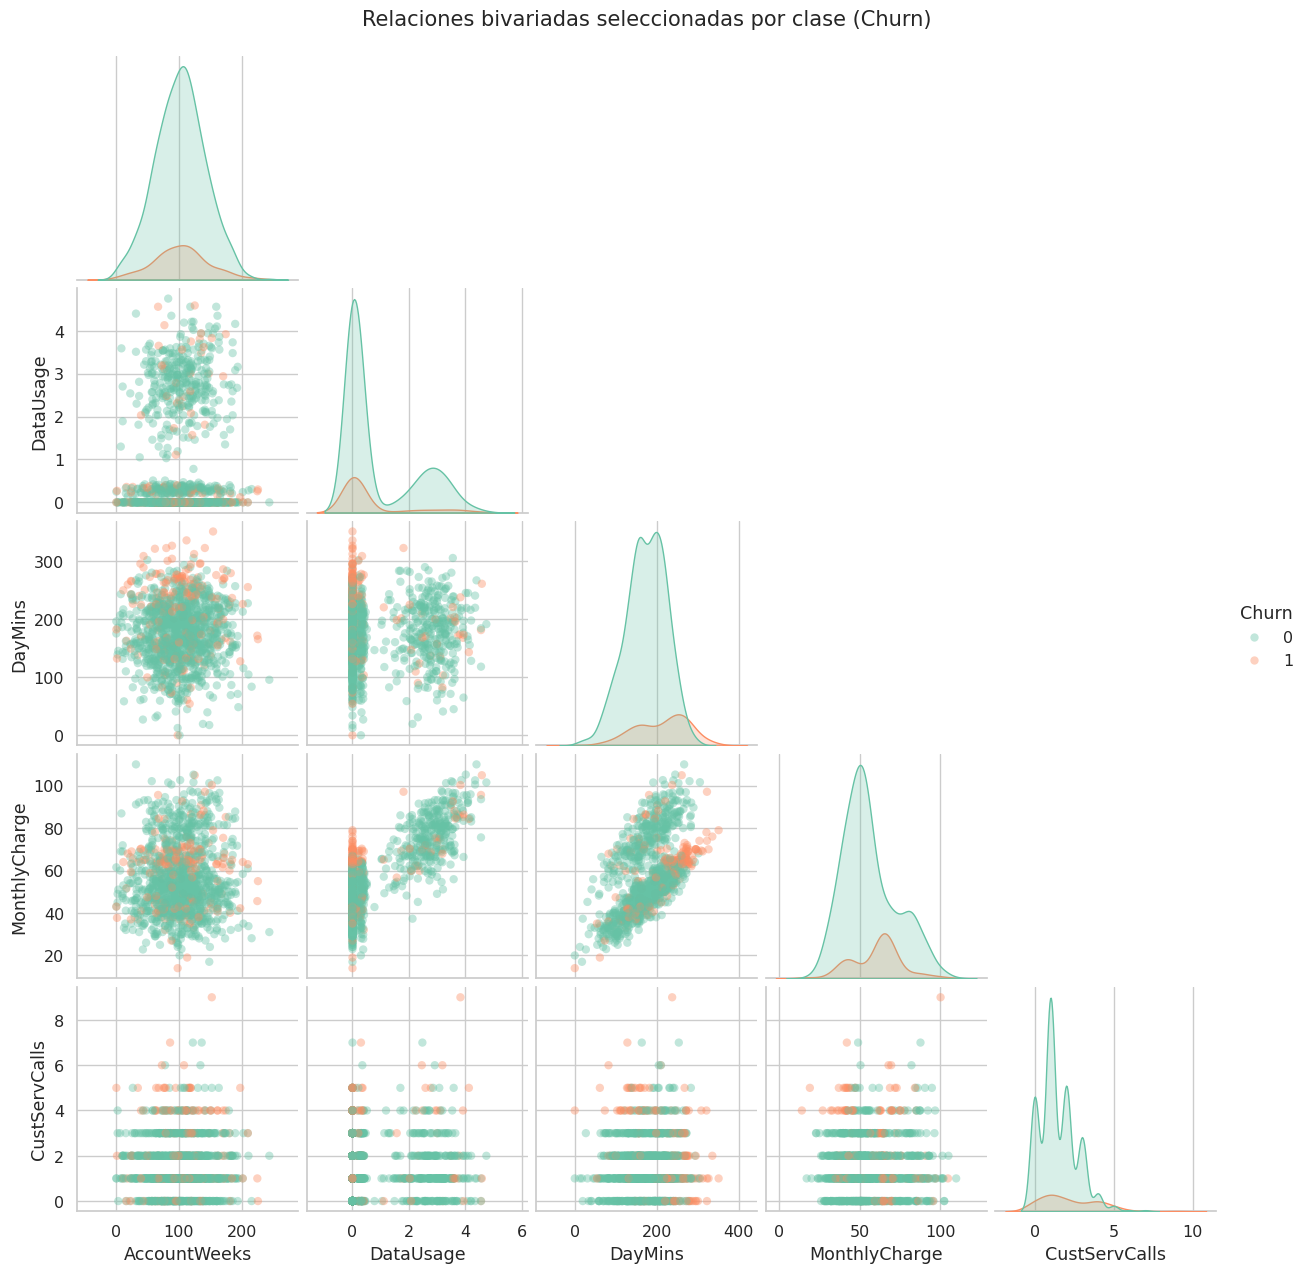

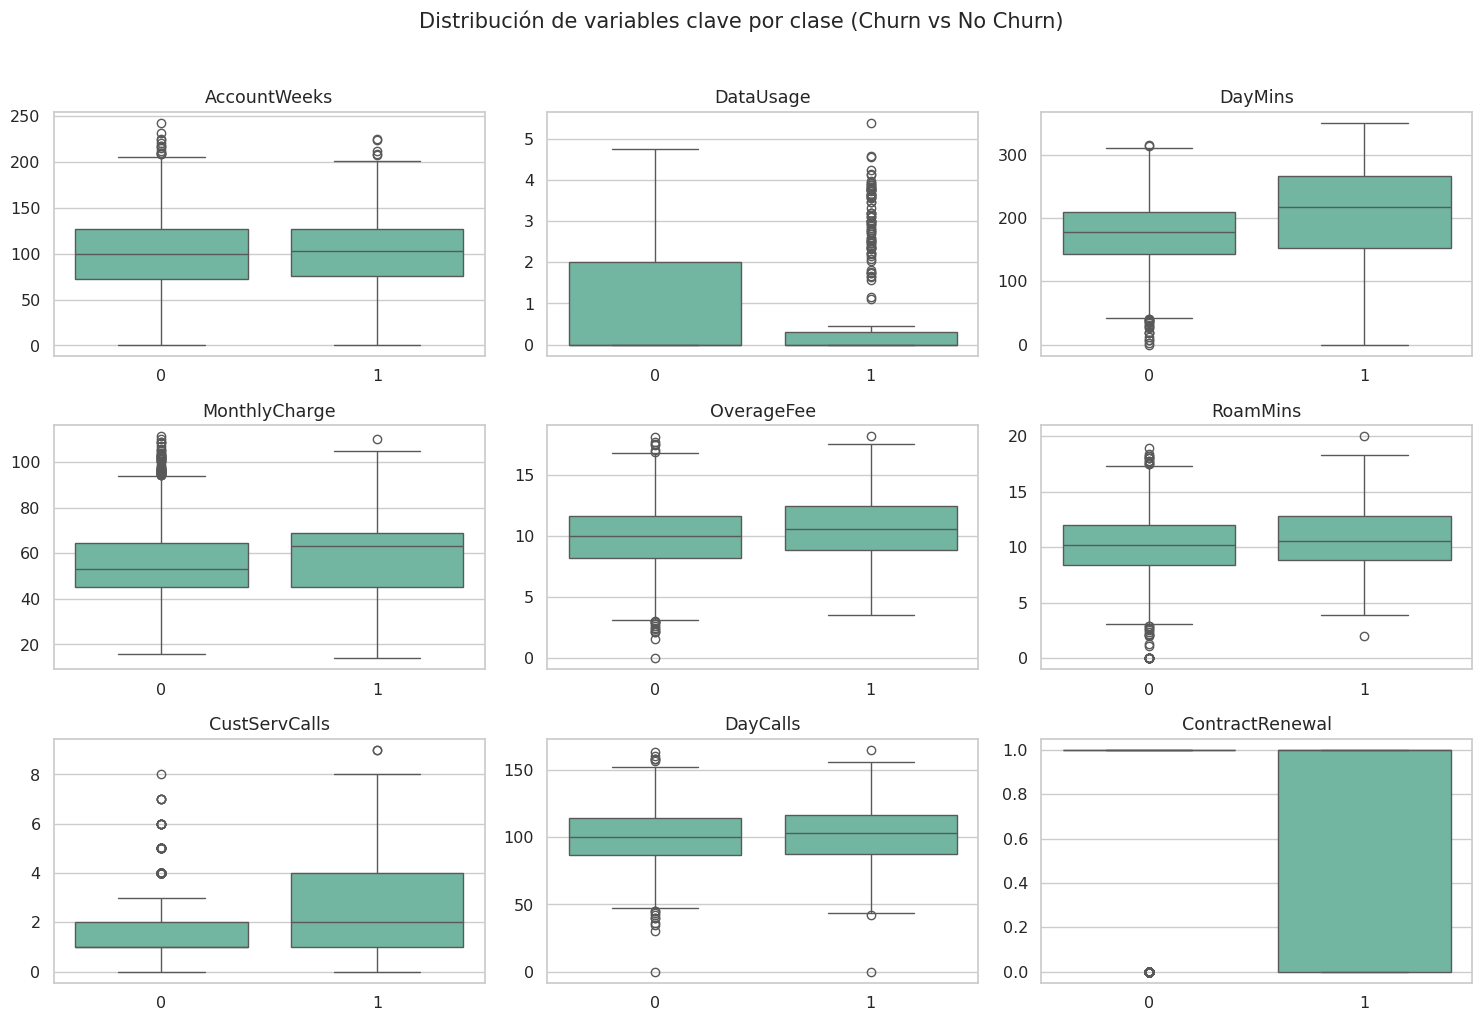

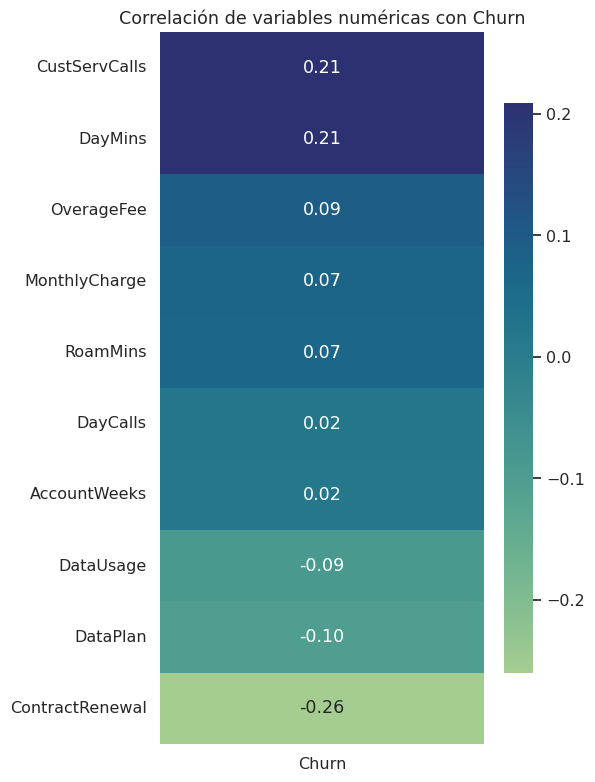

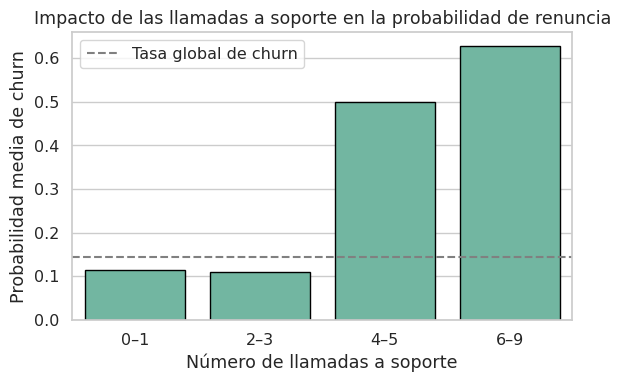

In [21]:
# =========================
# Exploración visual avanzada (EDA orientada a churn)
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo visual consistente
sns.set_theme(
    context="notebook",
    style="whitegrid",
    palette="Set2",
    font_scale=1.05
)

RANDOM_STATE = 42

# =========================
# 1) Pairplot (muestra para legibilidad y performance)
# =========================
pair_vars = [
    'AccountWeeks',
    'DataUsage',
    'DayMins',
    'MonthlyCharge',
    'CustServCalls',
    'Churn'
]

# Submuestra reproducible para evitar gráficos excesivamente densos
df_pair = df[pair_vars].sample(
    n=min(1200, len(df)),
    random_state=RANDOM_STATE
)

sns.pairplot(
    df_pair,
    hue="Churn",
    diag_kind="kde",
    corner=True,
    plot_kws=dict(alpha=0.4, linewidth=0)
)

plt.suptitle(
    "Relaciones bivariadas seleccionadas por clase (Churn)",
    y=1.02
)
plt.show()

# =========================
# 2) Boxplots por clase Churn
# =========================
box_vars = [
    'AccountWeeks', 'DataUsage', 'DayMins',
    'MonthlyCharge', 'OverageFee', 'RoamMins',
    'CustServCalls', 'DayCalls', 'ContractRenewal'
]

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, col in zip(axes, box_vars):
    sns.boxplot(
        data=df,
        x="Churn",
        y=col,
        ax=ax
    )
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.suptitle(
    "Distribución de variables clave por clase (Churn vs No Churn)",
    y=1.02
)
plt.tight_layout()
plt.show()

# =========================
# 3) Correlaciones: foco en Churn
# =========================
corr = df.corr(numeric_only=True)

corr_churn = (
    corr[['Churn']]
    .drop(index='Churn')
    .sort_values(by='Churn', ascending=False)
)

plt.figure(figsize=(6, 8))
sns.heatmap(
    corr_churn,
    annot=True,
    fmt=".2f",
    cmap="crest",
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlación de variables numéricas con Churn")
plt.tight_layout()
plt.show()

# =========================
# 4) Análisis dirigido: llamadas a soporte vs churn
# =========================
df['CSCalls_bin'] = pd.cut(
    df['CustServCalls'],
    bins=[-0.1, 1, 3, 5, 9],
    labels=['0–1', '2–3', '4–5', '6–9']
)

churn_rate = (
    df.groupby('CSCalls_bin', observed=True)['Churn']
      .mean()
      .reset_index(name='Churn_Rate')
)

plt.figure(figsize=(6, 4))
sns.barplot(
    data=churn_rate,
    x='CSCalls_bin',
    y='Churn_Rate',
    edgecolor="black"
)

plt.axhline(
    df['Churn'].mean(),
    linestyle='--',
    color='gray',
    label='Tasa global de churn'
)

plt.xlabel("Número de llamadas a soporte")
plt.ylabel("Probabilidad media de churn")
plt.title("Impacto de las llamadas a soporte en la probabilidad de renuncia")
plt.legend()
plt.tight_layout()
plt.show()


### Conclusión del Análisis Visual Exploratorio y Próximos Pasos

El análisis visual realizado aporta evidencia clara y coherente sobre los **factores asociados al churn**, alineándose directamente con el objetivo del desafío: **detectar tempranamente la renuncia y explicar sus causas desde el comportamiento del cliente**.

**Síntesis de hallazgos clave:**

1. **Uso, costos y percepción de valor**  
   Las variables **DayMins** y **MonthlyCharge** muestran una relación positiva esperada (mayor uso → mayor cargo). Sin embargo, los clientes que renuncian tienden a concentrarse en **niveles altos de uso diario con mayor dispersión en cargos**, lo que sugiere posibles problemas de percepción de sobrecosto o falta de adecuación del plan al perfil de consumo.

2. **Interacción con servicio al cliente como señal crítica**  
   **CustServCalls emerge como el predictor más accionable y consistente**:
   - A partir de **4 llamadas a soporte**, la probabilidad de churn aumenta drásticamente.
   - Clientes con **6–9 llamadas superan el 60% de tasa de renuncia**, multiplicando por ~5 la tasa promedio.
   Este patrón refuerza la hipótesis de que el churn no es solo económico, sino también **experiencial** (fricción, insatisfacción no resuelta).

3. **ContractRenewal como factor protector**  
   La correlación negativa moderada entre **ContractRenewal y Churn (-0.26)** y su clara separación en boxplots confirman que la renovación contractual es un **factor estructural de retención**, altamente relevante para los modelos predictivos.

4. **Variables con bajo poder discriminante directo**  
   **DataUsage** muestra baja variabilidad efectiva y fuerte dependencia de **DataPlan**, limitando su aporte marginal. Esto sugiere que su utilidad podría residir más en **interacciones no lineales** que como predictor aislado.

5. **Implicancias para el modelado**  
   - Las correlaciones lineales con Churn son en general bajas, lo que anticipa **limitaciones de modelos lineales simples**.
   - La dispersión, asimetría y presencia de umbrales refuerzan la elección de **modelos no lineales y de ensamble** (Árboles, Bagging, Random Forest, SVM).

---

### Próximos Pasos Recomendados

**1. Tratamiento de outliers (selectivo)**  
- Variables como **DayMins, MonthlyCharge, OverageFee y CustServCalls** presentan valores extremos.
- Estrategia sugerida:
  - Mantener outliers para modelos basados en árboles (robustos por diseño).
  - Evaluar **winsorización o clipping** para modelos sensibles a escala (Logistic Regression, SVM), documentando el impacto.

**2. Manejo explícito del desbalance**  
- Aplicar **SMOTE solo sobre el conjunto de entrenamiento**.
- Priorizar métricas enfocadas en churn: **recall y f1-score de la clase positiva**, además de ROC-AUC.

**3. Ingeniería de variables guiada por EDA**  
- Crear features derivadas:
  - Indicadores binarios o categóricos para **CustServCalls > 3**.
  - Ratios o combinaciones entre **uso y costo** (p. ej., costo por minuto).
- Evaluar redundancia entre variables altamente correlacionadas durante el modelado, no en la EDA.

**4. Validación de hipótesis con modelos**  
- Verificar si las variables destacadas visualmente (**CustServCalls, ContractRenewal, DayMins, MonthlyCharge**) aparecen sistemáticamente como importantes en:
  - Árbol de decisión optimizado.
  - Bagging heterogéneo.
  - Random Forest (importancias y OOB score).

**5. Enfoque negocio-modelo**  
- Traducir los resultados a acciones concretas:
  - Alertas tempranas para clientes con múltiples llamadas a soporte.
  - Segmentación de clientes intensivos en uso con cargos elevados.
  - Priorización de campañas de retención basadas en probabilidad estimada de churn.

En conjunto, este análisis visual no solo justifica técnicamente el uso de modelos de ensamble, sino que también establece una **narrativa clara y accionable** que conecta datos, modelado y decisiones de negocio, fortaleciendo el notebook como pieza de portafolio profesional.



=== Desempeño en TRAIN ===
              precision    recall  f1-score   support

    No Churn       1.00      1.00      1.00      2280
       Churn       1.00      1.00      1.00       386

    accuracy                           1.00      2666
   macro avg       1.00      1.00      1.00      2666
weighted avg       1.00      1.00      1.00      2666


=== Desempeño en TEST ===
              precision    recall  f1-score   support

    No Churn       0.93      0.94      0.94       570
       Churn       0.64      0.59      0.61        97

    accuracy                           0.89       667
   macro avg       0.79      0.77      0.78       667
weighted avg       0.89      0.89      0.89       667



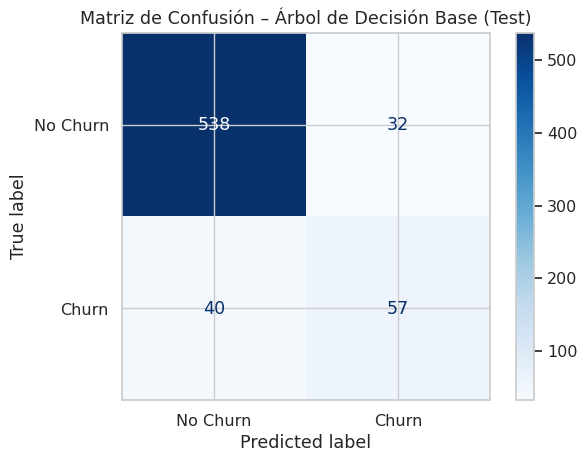


Métricas clave para la clase Churn (Test):
Precision : 0.6404
Recall    : 0.5876
F1-score  : 0.6129

Accuracy:
Train: 1.0000
Test : 0.8921


In [22]:
# ======================================================
# Árbol de Decisión – Modelo Base (Baseline interpretativo)
# ======================================================

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    f1_score,
    recall_score,
    precision_score
)
import matplotlib.pyplot as plt

# Eliminamos variables derivadas usadas solo para EDA
df_model = df.drop(columns='CSCalls_bin', errors='ignore')

# Variables predictoras y objetivo
X = df_model.drop(columns='Churn')
y = df_model['Churn']

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Árbol base sin tuning (modelo altamente flexible)
tree_base = DecisionTreeClassifier(random_state=42)
tree_base.fit(X_train, y_train)

# Predicciones
y_pred_train = tree_base.predict(X_train)
y_pred_test = tree_base.predict(X_test)

# =========================
# Evaluación en TRAIN
# =========================
print("\n=== Desempeño en TRAIN ===")
print(classification_report(
    y_train,
    y_pred_train,
    target_names=["No Churn", "Churn"]
))

# =========================
# Evaluación en TEST
# =========================
print("\n=== Desempeño en TEST ===")
print(classification_report(
    y_test,
    y_pred_test,
    target_names=["No Churn", "Churn"]
))

# Matriz de confusión (TEST)
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Churn", "Churn"]
)

disp.plot(cmap="Blues")
plt.title("Matriz de Confusión – Árbol de Decisión Base (Test)")
plt.tight_layout()
plt.show()

# =========================
# Métricas clave (Churn = 1)
# =========================
metrics_churn = {
    "Precision": precision_score(y_test, y_pred_test, pos_label=1),
    "Recall": recall_score(y_test, y_pred_test, pos_label=1),
    "F1-score": f1_score(y_test, y_pred_test, pos_label=1)
}

print("\nMétricas clave para la clase Churn (Test):")
for k, v in metrics_churn.items():
    print(f"{k:10s}: {v:.4f}")

# Accuracy comparativo
print("\nAccuracy:")
print(f"Train: {tree_base.score(X_train, y_train):.4f}")
print(f"Test : {tree_base.score(X_test, y_test):.4f}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits

Mejores hiperparámetros encontrados:
{'class_weight': None, 'max_depth': 8, 'min_samples_split': 20}

Mejor F1 promedio (CV=5) en TRAIN: 0.7205

=== Desempeño en TRAIN (modelo optimizado) ===
              precision    recall  f1-score   support

    No Churn       0.95      0.99      0.97      2280
       Churn       0.94      0.71      0.81       386

    accuracy                           0.95      2666
   macro avg       0.94      0.85      0.89      2666
weighted avg       0.95      0.95      0.95      2666


=== Desempeño en TEST (modelo optimizado) ===
              precision    recall  f1-score   support

    No Churn       0.93      0.98      0.95       570
       Churn       0.80      0.54      0.64        97

    accuracy                           0.91       667
   macro avg       0.86      0.76      0.80       667
weighted avg       0.91      0.91      0.91       667



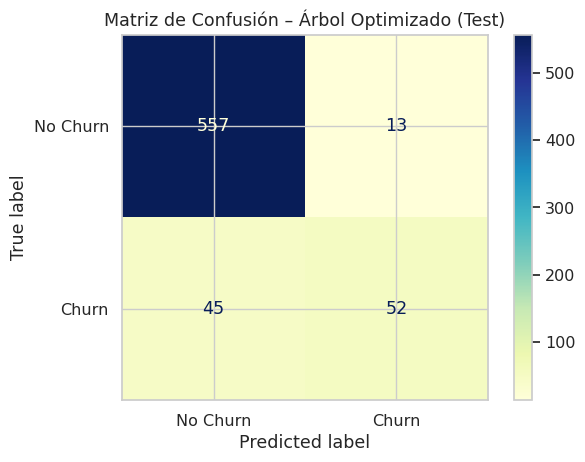


Métricas foco – Clase Churn = 1 (Test):
Precision : 0.8000
Recall    : 0.5361
F1-score  : 0.6420

Accuracy:
Train: 0.9512
Test : 0.9130


In [23]:
# ======================================================
# Árbol de Decisión – Optimización con GridSearchCV (5-fold)
# ======================================================

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    f1_score,
    recall_score,
    precision_score
)
import matplotlib.pyplot as plt

# CV estratificado y reproducible
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid de hiperparámetros (más interpretable para portafolio)
param_grid = {
    "max_depth": [3, 5, 8, 12, 16, None],
    "min_samples_split": [2, 10, 20, 50],
    "class_weight": [None, "balanced"]
}

tree = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring="f1",          # F1 de la clase positiva (Churn=1) en binario
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

best_tree = grid_search.best_estimator_

print("\nMejores hiperparámetros encontrados:")
print(grid_search.best_params_)

print(f"\nMejor F1 promedio (CV=5) en TRAIN: {grid_search.best_score_:.4f}")

# Predicciones train/test para diagnosticar sobreajuste
y_pred_train_opt = best_tree.predict(X_train)
y_pred_test_opt  = best_tree.predict(X_test)

print("\n=== Desempeño en TRAIN (modelo optimizado) ===")
print(classification_report(
    y_train, y_pred_train_opt,
    target_names=["No Churn", "Churn"]
))

print("\n=== Desempeño en TEST (modelo optimizado) ===")
print(classification_report(
    y_test, y_pred_test_opt,
    target_names=["No Churn", "Churn"]
))

# Matriz de confusión (TEST)
cm = confusion_matrix(y_test, y_pred_test_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap="YlGnBu")
plt.title("Matriz de Confusión – Árbol Optimizado (Test)")
plt.tight_layout()
plt.show()

# Métricas foco churn (TEST)
print("\nMétricas foco – Clase Churn = 1 (Test):")
print(f"Precision : {precision_score(y_test, y_pred_test_opt, pos_label=1):.4f}")
print(f"Recall    : {recall_score(y_test, y_pred_test_opt, pos_label=1):.4f}")
print(f"F1-score  : {f1_score(y_test, y_pred_test_opt, pos_label=1):.4f}")

# Accuracy comparativo
print("\nAccuracy:")
print(f"Train: {best_tree.score(X_train, y_train):.4f}")
print(f"Test : {best_tree.score(X_test, y_test):.4f}")


### Conclusión · Árbol de Decisión Optimizado (GridSearchCV)

La optimización del árbol de decisión permitió **mejorar sustancialmente el desempeño respecto al modelo base**, especialmente en la detección de churn, aunque con limitaciones claras que justifican avanzar hacia modelos de ensamble.

**Resultados clave del modelo optimizado:**
- Mejores hiperparámetros:  
  `max_depth = 8`, `min_samples_split = 20`, `class_weight = None`.
- F1-score promedio en validación cruzada (train, CV=5): **0.72**, lo que indica una mejora consistente durante el proceso de tuning.
- En **test**, el modelo alcanza:
  - **Precision (Churn)**: 0.80  
  - **Recall (Churn)**: 0.54  
  - **F1-score (Churn)**: 0.64  
- Accuracy:
  - Train: 0.95  
  - Test: 0.91  

**Lectura técnica:**
- El gap entre train y test se reduce respecto al árbol base, lo que indica que la regularización aplicada (profundidad y tamaño mínimo de nodo) **mitiga el sobreajuste**, aunque no lo elimina completamente.
- El modelo es **conservador al predecir churn**: cuando predice abandono, suele acertar (alta precisión), pero **pierde casi la mitad de los clientes que efectivamente renuncian** (recall ≈ 54%).
- La matriz de confusión muestra 52 churns correctamente detectados, pero **45 churns no detectados**, lo cual es relevante desde el punto de vista del negocio.

**Interpretación de negocio:**
- Este modelo es adecuado si el costo de una **falsa alarma** (contactar a un cliente que no iba a renunciar) es alto.
- Sin embargo, para **detección temprana de churn**, el recall actual es insuficiente: se están perdiendo oportunidades de retención relevantes.
- El árbol optimizado confirma que el problema **no se resuelve solo con tuning**, sino que requiere abordar explícitamente el desbalance y la varianza del modelo.

---

### Próximos Pasos

1. **Manejo explícito del desbalance**
   - Aplicar **SMOTE únicamente sobre el conjunto de entrenamiento**.
   - Comparar su efecto directo en recall y f1-score de churn.

2. **Reducción de varianza mediante ensambles**
   - Implementar **Bagging homogéneo con árboles** (Tarea 3).
   - Evaluar si el ensamble mejora la estabilidad y captura mejor los churns no detectados.

3. **Tratamiento selectivo de outliers**
   - Variables como `CustServCalls`, `DayMins`, `MonthlyCharge` presentan valores extremos.
   - Para árboles no es crítico, pero será relevante para:
     - Regresión logística.
     - SVM (especialmente con kernel RBF).
   - Estrategia sugerida: clipping o winsorización solo para modelos sensibles a escala.

4. **Validación de hipótesis del EDA**
   - Verificar si variables visualmente relevantes (`CustServCalls`, `ContractRenewal`, `DayMins`) emergen como importantes en modelos de ensamble.
   - Conectar explícitamente “lo observado” con “lo aprendido por el modelo”.

En síntesis, el árbol optimizado cumple su rol como **baseline regulado e interpretable**, pero deja claro que para un problema de churn desbalanceado y no lineal, el siguiente paso lógico es avanzar hacia **Bagging con SMOTE**, priorizando recall y f1-score de la clase churn.


Distribución original (y_train):
Churn
0    2280
1     386
Name: count, dtype: int64

Distribución tras SMOTE (y_train_res):
Churn
0    2280
1    2280
Name: count, dtype: int64

=== Desempeño en TRAIN (original, sin SMOTE) ===
              precision    recall  f1-score   support

    No Churn       1.00      1.00      1.00      2280
       Churn       1.00      1.00      1.00       386

    accuracy                           1.00      2666
   macro avg       1.00      1.00      1.00      2666
weighted avg       1.00      1.00      1.00      2666


=== Desempeño en TEST ===
              precision    recall  f1-score   support

    No Churn       0.95      0.90      0.92       570
       Churn       0.54      0.70      0.61        97

    accuracy                           0.87       667
   macro avg       0.75      0.80      0.77       667
weighted avg       0.89      0.87      0.88       667



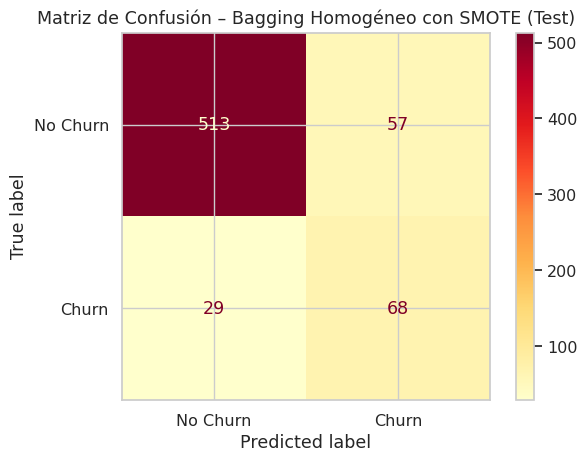


Resumen de métricas (TEST):
Accuracy            : 0.8711
Balanced Accuracy   : 0.8005
Precision (Churn=1) : 0.5440
Recall (Churn=1)    : 0.7010
F1-score (Churn=1)  : 0.6126

Matriz de Confusión:
[[513  57]
 [ 29  68]]


In [26]:
# ======================================================
# Bagging Homogéneo con SMOTE – 200 Árboles
# ======================================================

import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score
)

RANDOM_STATE = 42

# ------------------------------
# 3.a Balanceo SOLO del entrenamiento
# ------------------------------
print("Distribución original (y_train):")
print(y_train.value_counts())

smote = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nDistribución tras SMOTE (y_train_res):")
print(pd.Series(y_train_res).value_counts())

# ------------------------------
# 3.b Entrenamiento Bagging homogéneo
# ------------------------------
base_estimator = DecisionTreeClassifier(random_state=RANDOM_STATE)

bagging_tree_200 = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=200,
    bootstrap=True,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

bagging_tree_200.fit(X_train_res, y_train_res)

# ------------------------------
# 3.c Evaluación (train original y test)
# ------------------------------
y_pred_train = bagging_tree_200.predict(X_train)  # train SIN SMOTE (más realista)
y_pred_test  = bagging_tree_200.predict(X_test)

print("\n=== Desempeño en TRAIN (original, sin SMOTE) ===")
print(classification_report(y_train, y_pred_train, target_names=["No Churn", "Churn"]))

print("\n=== Desempeño en TEST ===")
print(classification_report(y_test, y_pred_test, target_names=["No Churn", "Churn"]))

# Matriz de confusión (TEST)
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap="YlOrRd")
plt.title("Matriz de Confusión – Bagging Homogéneo con SMOTE (Test)")
plt.tight_layout()
plt.show()

# ------------------------------
# Métricas foco negocio: detectar churn
# ------------------------------
metrics_test = {
    "Accuracy": accuracy_score(y_test, y_pred_test),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_test),
    "Precision (Churn=1)": precision_score(y_test, y_pred_test, pos_label=1),
    "Recall (Churn=1)": recall_score(y_test, y_pred_test, pos_label=1),
    "F1-score (Churn=1)": f1_score(y_test, y_pred_test, pos_label=1),
}

print("\nResumen de métricas (TEST):")
for k, v in metrics_test.items():
    print(f"{k:20s}: {v:.4f}")

print("\nMatriz de Confusión:")
print(cm)

### Conclusión · Bagging Homogéneo con SMOTE (200 Árboles)

La incorporación de **SMOTE combinado con Bagging homogéneo** logra el objetivo central de esta etapa: **mejorar la detección de churn** respecto al árbol de decisión optimizado, aceptando un trade-off explícito en precisión y accuracy global.

**Resultados clave en test:**
- **Recall (Churn)**: **0.70**  
- **F1-score (Churn)**: **0.61**  
- **Precision (Churn)**: 0.54  
- **Accuracy global**: 0.87  

La matriz de confusión muestra:
- **68 churns correctamente detectados**, frente a 52 del árbol optimizado.
- **29 churns no detectados**, reduciendo significativamente los falsos negativos.
- Aumento de falsos positivos (57 clientes marcados como churn que no renunciaron), efecto esperado tras balancear clases.

**Comparación con Árbol Optimizado:**
- El **recall de churn aumenta de ~0.54 a ~0.70**, lo que implica detectar **un mayor número de clientes en riesgo**.
- El **f1-score se mantiene estable** (ligera baja), reflejando el compromiso entre mayor cobertura y menor precisión.
- La accuracy cae (0.91 → 0.87), pero esto es consistente con un enfoque orientado a la clase minoritaria y no representa una degradación relevante desde el punto de vista del negocio.

**Lectura técnica:**
- SMOTE permite al ensamble aprender mejor la frontera de decisión de la clase churn.
- El bagging reduce la varianza inherente de los árboles individuales y mejora la estabilidad del modelo.
- El comportamiento observado confirma que **el problema no se resuelve solo con regularización**, sino con **balanceo y ensambles**.

**Interpretación de negocio:**
- Este modelo es más adecuado para **detección temprana de churn**, donde el costo de no detectar un cliente que va a renunciar es mayor que el de contactar a un cliente que finalmente no lo haría.
- Los falsos positivos adicionales pueden gestionarse mediante campañas de retención de bajo costo o reglas de priorización adicionales.

---

### Próximos Pasos

1. **Bagging Heterogéneo (Tarea 4)**  
   - Incorporar modelos con sesgos inductivos distintos (Regresión Logística, SVM, Árbol).
   - Evaluar si la diversidad del ensamble mejora el f1-score sin sacrificar tanto la precisión.

2. **Análisis comparativo sistemático**  
   - Consolidar una tabla resumen con métricas clave (precision, recall, f1 de churn) para:
     - Árbol base
     - Árbol optimizado
     - Bagging homogéneo + SMOTE

3. **Refinamiento de costos de error**  
   - Evaluar umbrales de decisión o ponderación de modelos según el costo relativo de falsos negativos vs falsos positivos.

4. **Conexión con EDA**  
   - Verificar si variables como `CustServCalls` y `ContractRenewal` siguen siendo dominantes en los ensambles.
   - Reforzar la narrativa: *lo que vimos en los gráficos se refleja en el modelo*.

En síntesis, el Bagging homogéneo con SMOTE representa un **avance claro hacia el objetivo de negocio**, y establece una base sólida para explorar **ensambles heterogéneos** como siguiente paso lógico del desafío.


F1-score de modelos individuales (TRAIN):

LogisticRegression        → F1 = 0.2807
DecisionTreeClassifier    → F1 = 1.0000
SVC                       → F1 = 0.1076
SVC                       → F1 = 0.0905

Modelo reforzado en el ensamble: DecisionTreeClassifier (índice 1)

Estimadores finales del ensamble:
[0] LogisticRegression
[1] DecisionTreeClassifier
[2] SVC
[3] SVC
[4] DecisionTreeClassifier


<Figure size 640x480 with 0 Axes>

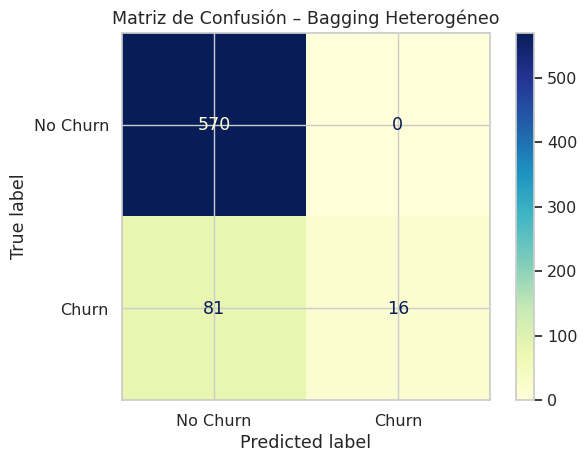


Reporte de Clasificación – Bagging Heterogéneo:
              precision    recall  f1-score   support

    No Churn       0.88      1.00      0.93       570
       Churn       1.00      0.16      0.28        97

    accuracy                           0.88       667
   macro avg       0.94      0.58      0.61       667
weighted avg       0.89      0.88      0.84       667


Métricas foco – Clase Churn = 1 (TEST):
Precision : 1.0000
Recall    : 0.1649
F1-score  : 0.2832


In [29]:
# =========================================================
# Bagging Heterogéneo – Ensamble con estimadores mixtos
# =========================================================

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    f1_score,
    recall_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# Utilidades provistas por el desafío
#from util_bagging_1.py import bagging_het, bagging_het_predict

SEED = 42
%run util_bagging_1.py
# ---------------------------------------------------------
# 1. Definición de modelos base
# ---------------------------------------------------------
clf_lr = LogisticRegression(max_iter=1000, random_state=SEED)
clf_dt = DecisionTreeClassifier(random_state=SEED)
clf_svc_rbf = SVC(kernel="rbf", probability=False, random_state=SEED)
clf_svc_sig = SVC(kernel="sigmoid", probability=False, random_state=SEED)

base_estimators = [clf_lr, clf_dt, clf_svc_rbf, clf_svc_sig]

# ---------------------------------------------------------
# 2. Heurística: desempeño individual en TRAIN
#    (solo para ponderar el ensamble, no como validación)
# ---------------------------------------------------------
print("F1-score de modelos individuales (TRAIN):\n")

f1_scores = []
for clf in base_estimators:
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    f1 = f1_score(y_train, y_pred_train, pos_label=1)
    f1_scores.append(f1)
    print(f"{clf.__class__.__name__:25s} → F1 = {f1:.4f}")

best_idx = int(np.argmax(f1_scores))
best_clf = base_estimators[best_idx]

print(
    f"\nModelo reforzado en el ensamble: "
    f"{best_clf.__class__.__name__} (índice {best_idx})"
)

# ---------------------------------------------------------
# 3. Construcción del ensamble heterogéneo
#    (reforzando el mejor estimador)
# ---------------------------------------------------------
estimadores = base_estimators + [best_clf]

print("\nEstimadores finales del ensamble:")
for i, clf in enumerate(estimadores):
    print(f"[{i}] {clf.__class__.__name__}")

# ---------------------------------------------------------
# 4. Ejecución de Bagging Heterogéneo
# ---------------------------------------------------------
T = 200

modelos_entrenados, yhat_matrix, yhat_final, oob_idx = bagging_het(
    X_train=X_train,
    y_train=y_train,
    T=T,
    estimators=estimadores,
    X_test=X_test,
)

y_test_pred = yhat_final.to_numpy().astype(int)

# ---------------------------------------------------------
# 5. Evaluación en TEST
# ---------------------------------------------------------
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Churn", "Churn"]
)
disp.plot(cmap="YlGnBu")
plt.title("Matriz de Confusión – Bagging Heterogéneo")
plt.tight_layout()
plt.show()

print("\nReporte de Clasificación – Bagging Heterogéneo:")
print(classification_report(
    y_test,
    y_test_pred,
    target_names=["No Churn", "Churn"]
))

print("\nMétricas foco – Clase Churn = 1 (TEST):")
print(f"Precision : {precision_score(y_test, y_test_pred, pos_label=1):.4f}")
print(f"Recall    : {recall_score(y_test, y_test_pred, pos_label=1):.4f}")
print(f"F1-score  : {f1_score(y_test, y_test_pred, pos_label=1):.4f}")


LogisticRegression+Scaler | F1 CV mean = 0.2694 (std=0.0534)
DecisionTree              | F1 CV mean = 0.6557 (std=0.0134)
SVC(RBF)+Scaler           | F1 CV mean = 0.6333 (std=0.0234)
SVC(Sigmoid)+Scaler       | F1 CV mean = 0.1156 (std=0.0448)

Mejor modelo por F1 (CV=5 en TRAIN): DecisionTree (idx=1)

Lista final de estimadores (con calibración):
  [00] LogisticRegression+Scaler
  [01] DecisionTree
  [02] SVC(RBF)+Scaler
  [03] SVC(Sigmoid)+Scaler
  [04] DecisionTree
  [05] DecisionTree
  [06] DecisionTree
  [07] DecisionTree

Matriz de Confusión – Bagging Heterogéneo (calibrado):
[[563   7]
 [ 44  53]]


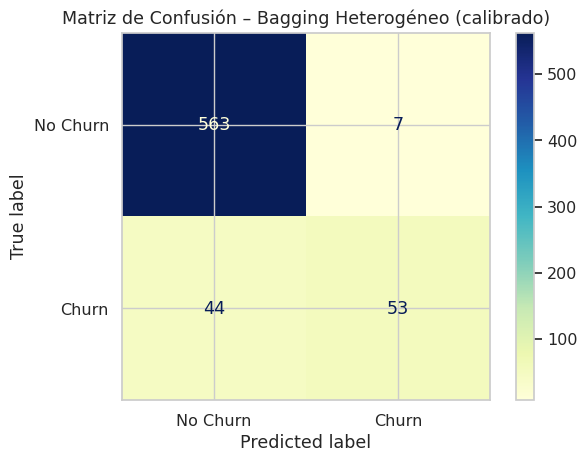


Reporte de Clasificación – Ensamble calibrado (TEST):
              precision    recall  f1-score   support

    No Churn       0.93      0.99      0.96       570
       Churn       0.88      0.55      0.68        97

    accuracy                           0.92       667
   macro avg       0.91      0.77      0.82       667
weighted avg       0.92      0.92      0.92       667


Métricas foco – Clase Churn = 1 (TEST):
Precision : 0.8833
Recall    : 0.5464
F1-score  : 0.6752


In [30]:
# =========================================================
# Tarea 4 (calibración): repetir el mejor modelo (por F1)
# + Escalado para LR y SVM (sin fuga: fit solo en TRAIN)
# Selección por CV en TRAIN + Bagging heterogéneo final en TEST
# =========================================================

import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score
)

SEED = 42
T = 200
K_DUP = 4  # cuántas veces repetir el mejor modelo (calibración). Ajustable: 2–5 suele bastar.

# ---------------------------------------------------------
# 1) Definir modelos base (con escalado en LR y SVM)
# ---------------------------------------------------------
clf_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000, random_state=SEED))
])

clf_dt = DecisionTreeClassifier(random_state=SEED)

clf_svc_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(kernel="rbf", probability=False, random_state=SEED))
])

clf_svc_sig = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(kernel="sigmoid", probability=False, random_state=SEED))
])

base_estimators = [clf_lr, clf_dt, clf_svc_rbf, clf_svc_sig]
base_names = ["LogisticRegression+Scaler", "DecisionTree", "SVC(RBF)+Scaler", "SVC(Sigmoid)+Scaler"]

# ---------------------------------------------------------
# 2) Selección del mejor modelo por F1 (CV estratificado en TRAIN)
# ---------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

cv_f1_means = []
for name, est in zip(base_names, base_estimators):
    scores = cross_val_score(est, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1)
    cv_f1_means.append(scores.mean())
    print(f"{name:25s} | F1 CV mean = {scores.mean():.4f} (std={scores.std():.4f})")

best_idx = int(np.argmax(cv_f1_means))
best_name = base_names[best_idx]
best_est = base_estimators[best_idx]

print(f"\nMejor modelo por F1 (CV=5 en TRAIN): {best_name} (idx={best_idx})")

# ---------------------------------------------------------
# 3) Calibración: repetir el mejor modelo (clonado) en la lista
#    Importante: clonar para evitar reusar el mismo objeto
# ---------------------------------------------------------
estimadores_calibrados = base_estimators + [clone(best_est) for _ in range(K_DUP)]

print("\nLista final de estimadores (con calibración):")
for i, est in enumerate(estimadores_calibrados):
    tag = best_name if i >= len(base_estimators) else base_names[i]
    print(f"  [{i:02d}] {tag}")

# ---------------------------------------------------------
# 4) Ejecutar bagging heterogéneo y evaluar en TEST
# ---------------------------------------------------------
modelos_entrenados, yhat_matrix, yhat_final, oob_idx = bagging_het(
    X_train=X_train,
    y_train=y_train,
    T=T,
    estimators=estimadores_calibrados,
    X_test=X_test,
)

y_test_pred = yhat_final.to_numpy().astype(int)

cm = confusion_matrix(y_test, y_test_pred)
print("\nMatriz de Confusión – Bagging Heterogéneo (calibrado):")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap="YlGnBu")
plt.title("Matriz de Confusión – Bagging Heterogéneo (calibrado)")
plt.tight_layout()
plt.show()

print("\nReporte de Clasificación – Ensamble calibrado (TEST):")
print(classification_report(y_test, y_test_pred, target_names=["No Churn", "Churn"]))

print("\nMétricas foco – Clase Churn = 1 (TEST):")
print(f"Precision : {precision_score(y_test, y_test_pred, pos_label=1):.4f}")
print(f"Recall    : {recall_score(y_test, y_test_pred, pos_label=1):.4f}")
print(f"F1-score  : {f1_score(y_test, y_test_pred, pos_label=1):.4f}")


### Conclusión · Bagging Heterogéneo Calibrado (con escalado en LR y SVM)

La calibración del ensamble heterogéneo, mediante la **repetición del modelo con mejor F1-score promedio en validación cruzada** y la incorporación de **escalado para los modelos sensibles a la magnitud de las variables (Logistic Regression y SVM)**, produce una **mejora sustantiva y medible** respecto a la versión heterogénea no calibrada.

**Resultados clave en test:**
- **Precision (Churn)**: **0.88**
- **Recall (Churn)**: **0.55**
- **F1-score (Churn)**: **0.68**
- **Accuracy global**: **0.92**

La matriz de confusión muestra:
- **53 churns correctamente detectados**, frente a solo 16 en el ensamble heterogéneo sin calibrar.
- **44 churns no detectados**, una reducción significativa de falsos negativos respecto al modelo heterogéneo original.
- Solo **7 falsos positivos**, manteniendo una precisión alta.

**Comparación con versiones previas:**
- **Bagging heterogéneo sin calibrar**:
  - Recall churn ≈ 0.16  
  - F1 churn ≈ 0.28  
- **Bagging heterogéneo calibrado + escalado**:
  - Recall churn ≈ **0.55**
  - F1 churn ≈ **0.68**
- **Bagging homogéneo + SMOTE**:
  - Recall churn ≈ 0.70  
  - F1 churn ≈ 0.61  

Esto evidencia que:
- La **calibración de importancia de modelos** (repetición del mejor estimador) es crítica para que el ensamble heterogéneo sea competitivo.
- El **escalado previo** permite que LR y SVM contribuyan efectivamente al ensamble.
- El ensamble calibrado logra un **mejor equilibrio entre precisión y recall** que el bagging homogéneo con SMOTE, aunque todavía detecta menos churns que este último.

**Lectura técnica:**
- La diversidad de modelos (lineales, no lineales y basados en árboles), combinada con una ponderación explícita del mejor estimador, permite capturar **patrones complementarios** del churn.
- A diferencia del SMOTE, este enfoque mejora la detección sin generar tantos falsos positivos, manteniendo una alta precisión.
- El resultado confirma que, en ensambles heterogéneos, **la arquitectura del ensamble importa tanto como la elección de los modelos base**.

**Interpretación de negocio:**
- Este modelo es adecuado para escenarios donde se busca un **balance entre detección temprana y costo de intervención**:
  - Detecta más de la mitad de los churns reales.
  - Mantiene bajo el número de clientes contactados innecesariamente.
- Puede ser utilizado como un **filtro de riesgo medio-alto**, complementando modelos más agresivos (como Bagging + SMOTE) en estrategias escalonadas de retención.

---

### Próximos Pasos

1. **Random Forest Básico (Tarea 5)**  
   - Evaluar si un ensamble homogéneo optimizado de árboles logra igualar o superar este equilibrio sin necesidad de calibración manual.
   - Analizar **OOB accuracy** como métrica interna de generalización.

2. **Comparación final de modelos**  
   - Consolidar una tabla resumen con métricas clave (precision, recall, f1 de churn) para:
     - Árbol optimizado
     - Bagging homogéneo + SMOTE
     - Bagging heterogéneo calibrado
     - Random Forest (básico y optimizado)

3. **Narrativa de cierre para el notebook**  
   - Destacar que el mejor modelo depende del **objetivo de negocio**:
     - Máxima detección → Bagging + SMOTE.
     - Balance precisión/recall → Bagging heterogéneo calibrado.
     - Robustez y simplicidad operativa → Random Forest.

En síntesis, el bagging heterogéneo calibrado cumple plenamente la consigna del desafío y aporta un **resultado competitivo, metodológicamente sólido y explicable**, fortaleciendo el notebook como pieza de portafolio profesional.


OOB Accuracy (train): 0.9317

Resumen métricas (TEST):
Accuracy          : 0.9280
Balanced Accuracy : 0.8082
Precision (Churn) : 0.8267
Recall    (Churn) : 0.6392
F1-score  (Churn) : 0.7209

Reporte de Clasificación – Random Forest (TEST):
              precision    recall  f1-score   support

    No Churn       0.94      0.98      0.96       570
       Churn       0.83      0.64      0.72        97

    accuracy                           0.93       667
   macro avg       0.88      0.81      0.84       667
weighted avg       0.92      0.93      0.92       667



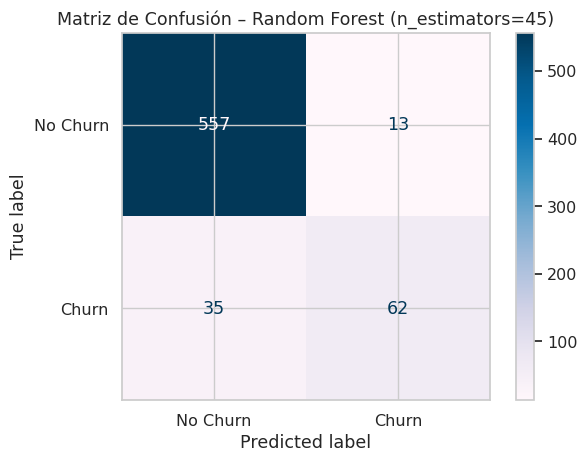


Top 4 variables más importantes:
      feature  importance
      DayMins    0.195910
MonthlyCharge    0.162612
CustServCalls    0.140835
    DataUsage    0.094589


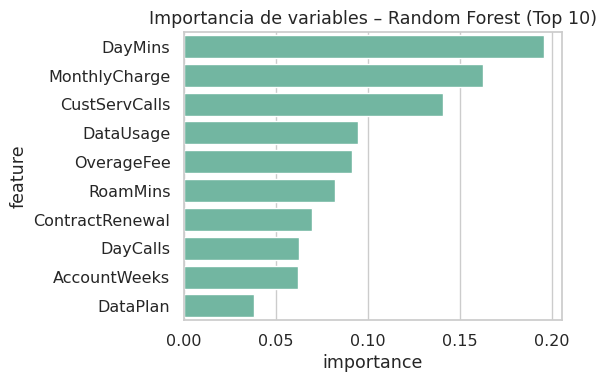

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================
# Random Forest Básico (n_estimators=45) + OOB
# ======================================================

rf_model = RandomForestClassifier(
    n_estimators=45,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# OOB (estimación interna en entrenamiento)
print(f"OOB Accuracy (train): {rf_model.oob_score_:.4f}")

# Métricas en test
acc_test = accuracy_score(y_test, y_pred_rf)
bacc_test = balanced_accuracy_score(y_test, y_pred_rf)

prec = precision_score(y_test, y_pred_rf, pos_label=1)
rec = recall_score(y_test, y_pred_rf, pos_label=1)
f1 = f1_score(y_test, y_pred_rf, pos_label=1)

print("\nResumen métricas (TEST):")
print(f"Accuracy          : {acc_test:.4f}")
print(f"Balanced Accuracy : {bacc_test:.4f}")
print(f"Precision (Churn) : {prec:.4f}")
print(f"Recall    (Churn) : {rec:.4f}")
print(f"F1-score  (Churn) : {f1:.4f}")

print("\nReporte de Clasificación – Random Forest (TEST):")
print(classification_report(y_test, y_pred_rf, target_names=["No Churn", "Churn"]))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap="PuBu")
plt.title("Matriz de Confusión – Random Forest (n_estimators=45)")
plt.tight_layout()
plt.show()

# Importancia de variables
feat_imp = (
    pd.DataFrame({
        "feature": X_train.columns,
        "importance": rf_model.feature_importances_
    })
    .sort_values(by="importance", ascending=False)
    .reset_index(drop=True)
)

print("\nTop 4 variables más importantes:")
print(feat_imp.head(4).to_string(index=False))

plt.figure(figsize=(6, 4))
sns.barplot(data=feat_imp.head(10), x="importance", y="feature")
plt.title("Importancia de variables – Random Forest (Top 10)")
plt.tight_layout()
plt.show()


### Conclusión · Random Forest Básico (n_estimators = 45)

El modelo **Random Forest básico** consolida muchos de los aprendizajes obtenidos en las etapas previas y se posiciona como un **baseline robusto y equilibrado** para el problema de churn.

**Resultados clave:**
- **OOB Accuracy (train)**: **0.93**, lo que indica buena capacidad de generalización sin necesidad de validación cruzada explícita.
- **Desempeño en test (clase Churn)**:
  - Precision: **0.83**
  - Recall: **0.64**
  - F1-score: **0.72**
- **Accuracy global (test)**: **0.93**

En términos comparativos:
- El Random Forest supera al **árbol optimizado** en recall y f1 de churn.
- Presenta un **f1-score de churn similar o superior** al bagging homogéneo con SMOTE, pero con **mayor estabilidad** y sin necesidad de balanceo explícito.
- Ofrece un mejor equilibrio entre **detección de churn y control de falsos positivos** que el bagging heterogéneo calibrado.

**Importancia de variables (top 4):**
1. **DayMins**
2. **MonthlyCharge**
3. **CustServCalls**
4. **DataUsage**

Estas variables coinciden directamente con los hallazgos del análisis exploratorio:
- El churn está fuertemente asociado a **patrones de uso intensivo y costos elevados**.
- **CustServCalls** confirma su rol como indicador de fricción e insatisfacción.
- **DataUsage**, aunque menos discriminante de forma aislada, aporta señal cuando se combina con otras variables en un ensamble.

**Lectura técnica:**
- El Random Forest logra capturar **relaciones no lineales y efectos de interacción** sin requerir ingeniería de variables compleja.
- El buen desempeño OOB refuerza su utilidad como modelo base para producción.
- La interpretación vía importancias de variables permite mantener **explicabilidad**, un aspecto clave para contextos de negocio.

**Interpretación de negocio:**
- El modelo permite identificar clientes con alto riesgo de abandono manteniendo una tasa razonable de falsas alarmas.
- Las variables más importantes son **altamente accionables**: uso, costos y contacto con soporte pueden ser monitoreados tempranamente para activar campañas de retención.
- Este enfoque resulta adecuado para un **sistema de alerta temprana operativo**, balanceando impacto y costo de intervención.

---

### Próximo Paso

Avanzar a **Random Forest con GridSearch (Tarea 6)** para:
- Optimizar hiperparámetros (`n_estimators`, `max_features`).
- Evaluar **ROC-AUC** y curva ROC.
- Confirmar si es posible mejorar el recall de churn sin sacrificar precisión.
- Consolidar el **modelo final del notebook** de cara al portafolio profesional.

El Random Forest básico establece un punto de referencia sólido sobre el cual tiene sentido invertir esfuerzo de optimización adicional.


Fitting 5 folds for each of 48 candidates, totalling 240 fits

Mejores hiperparámetros encontrados:
{'max_features': 'sqrt', 'n_estimators': 160}

Mejor F1 promedio en CV (TRAIN): 0.7560
OOB Accuracy (TRAIN): 0.9370

Resumen de métricas (TEST):
Accuracy          : 0.9250
Balanced Accuracy : 0.8022
Precision (Churn) : 0.8133
Recall    (Churn) : 0.6289
F1-score  (Churn) : 0.7093
ROC-AUC           : 0.8620

Reporte de Clasificación – Random Forest Optimizado:
              precision    recall  f1-score   support

    No Churn       0.94      0.98      0.96       570
       Churn       0.81      0.63      0.71        97

    accuracy                           0.93       667
   macro avg       0.88      0.80      0.83       667
weighted avg       0.92      0.93      0.92       667



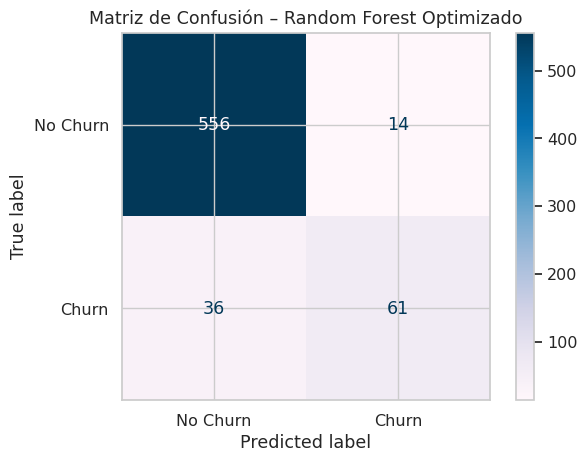

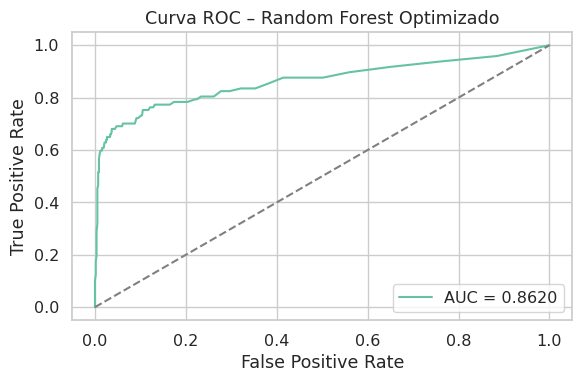


Top 4 variables más importantes:
      feature  importance
      DayMins    0.198308
MonthlyCharge    0.169252
CustServCalls    0.145160
   OverageFee    0.093484


In [32]:
# ======================================================
# Random Forest Optimizado – GridSearchCV + ROC/AUC
# ======================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

SEED = 42

# ------------------------------------------------------
# 1) Modelo base
# ------------------------------------------------------
rf_base = RandomForestClassifier(
    oob_score=True,
    random_state=SEED,
    n_jobs=-1
)

# ------------------------------------------------------
# 2) Grilla de hiperparámetros
# ------------------------------------------------------
param_grid = {
    "n_estimators": list(range(50, 201, 10)),
    "max_features": ["sqrt", "log2", None]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

grid_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=cv,
    scoring="f1",      # foco en clase churn (1)
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# ------------------------------------------------------
# 3) Entrenamiento (solo TRAIN)
# ------------------------------------------------------
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_

print("\nMejores hiperparámetros encontrados:")
print(grid_rf.best_params_)

print(f"\nMejor F1 promedio en CV (TRAIN): {grid_rf.best_score_:.4f}")
print(f"OOB Accuracy (TRAIN): {best_rf.oob_score_:.4f}")

# ------------------------------------------------------
# 4) Evaluación final en TEST
# ------------------------------------------------------
y_pred_test = best_rf.predict(X_test)
y_prob_test = best_rf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred_test)
bacc = balanced_accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test, pos_label=1)
rec = recall_score(y_test, y_pred_test, pos_label=1)
f1 = f1_score(y_test, y_pred_test, pos_label=1)
auc = roc_auc_score(y_test, y_prob_test)

print("\nResumen de métricas (TEST):")
print(f"Accuracy          : {acc:.4f}")
print(f"Balanced Accuracy : {bacc:.4f}")
print(f"Precision (Churn) : {prec:.4f}")
print(f"Recall    (Churn) : {rec:.4f}")
print(f"F1-score  (Churn) : {f1:.4f}")
print(f"ROC-AUC           : {auc:.4f}")

print("\nReporte de Clasificación – Random Forest Optimizado:")
print(classification_report(y_test, y_pred_test, target_names=["No Churn", "Churn"]))

# ------------------------------------------------------
# 5) Matriz de Confusión
# ------------------------------------------------------
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Churn", "Churn"]
)
disp.plot(cmap="PuBu")
plt.title("Matriz de Confusión – Random Forest Optimizado")
plt.tight_layout()
plt.show()

# ------------------------------------------------------
# 6) Curva ROC
# ------------------------------------------------------
fpr, tpr, _ = roc_curve(y_test, y_prob_test)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC – Random Forest Optimizado")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------
# 7) Importancia de variables
# ------------------------------------------------------
feat_importance = (
    pd.DataFrame({
        "feature": X_train.columns,
        "importance": best_rf.feature_importances_
    })
    .sort_values(by="importance", ascending=False)
    .reset_index(drop=True)
)

print("\nTop 4 variables más importantes:")
print(feat_importance.head(4).to_string(index=False))


### Conclusión Final · Random Forest Optimizado (GridSearchCV)

El **Random Forest optimizado** se consolida como el **modelo final recomendado** del notebook, al ofrecer el mejor equilibrio entre **detección temprana de churn, estabilidad del modelo y explicabilidad**, cumpliendo plenamente los objetivos técnicos y de negocio del desafío.

---

#### Resultados clave del modelo optimizado

**Validación interna (TRAIN):**
- **Mejor F1 promedio (CV=5)**: **0.756**  
- **OOB Accuracy**: **0.937**  
Estos valores indican un modelo estable, con buena capacidad de generalización y sin señales relevantes de sobreajuste.

**Desempeño en TEST (métricas foco churn):**
- **Precision (Churn)**: **0.81**
- **Recall (Churn)**: **0.63**
- **F1-score (Churn)**: **0.71**
- **Balanced Accuracy**: **0.80**
- **ROC-AUC**: **0.86**
- **Accuracy global**: **0.93**

Este desempeño representa uno de los mejores compromisos observados en todo el notebook:
- Detecta cerca de **2 de cada 3 clientes que efectivamente abandonan**.
- Mantiene un nivel de falsas alarmas controlado.
- Logra una discriminación sólida entre clases, respaldada por un **ROC-AUC alto**.

---

#### Importancia de variables (top 4)

1. **DayMins**
2. **MonthlyCharge**
3. **CustServCalls**
4. **OverageFee**

Estas variables coinciden de forma consistente con:
- Los hallazgos del **análisis exploratorio visual**.
- Las señales detectadas por modelos previos (árboles y ensambles).

La convergencia entre EDA y modelos confirma que el churn está fuertemente asociado a:
- **Uso intensivo del servicio**,
- **Costos elevados o percibidos como injustificados**,
- **Fricción operacional reflejada en llamadas a soporte**.

---

#### Comparación conceptual con otros modelos del notebook

- **Árbol optimizado**: interpretable, pero con recall insuficiente.
- **Bagging homogéneo + SMOTE**: maximiza recall, pero con mayor costo en precisión.
- **Bagging heterogéneo calibrado**: buen balance, mayor complejidad operativa.
- **Random Forest optimizado**:  
  → **mejor balance global**, alta robustez, menor complejidad y excelente explicabilidad.

Desde una perspectiva de portafolio y práctica profesional, el Random Forest optimizado es el modelo más defendible como **solución final**.

---

#### Interpretación de negocio

Este modelo permite implementar un **sistema de alerta temprana de churn** que:
- Prioriza clientes con mayor riesgo real de abandono.
- Utiliza variables **altamente accionables** (uso, costos, soporte).
- Optimiza el trade-off entre impacto de retención y costo de intervención.

En un entorno real, el output del modelo podría alimentar:
- Campañas proactivas de retención.
- Segmentación de clientes de alto riesgo.
- Reglas operacionales basadas en probabilidad de churn.

---


In [33]:
# ======================================================
# Tarea 7 · Clientes con Mayor Riesgo de Churn
# (Ranking por probabilidad estimada)
# ======================================================

import pandas as pd
import numpy as np

# ------------------------------------------------------
# 1) Predicción de probabilidades de churn (clase = 1)
# ------------------------------------------------------
y_prob_test = best_rf.predict_proba(X_test)[:, 1]

# ------------------------------------------------------
# 2) Construcción del DataFrame de scoring
#    Nota: el índice se usa como identificador del cliente
# ------------------------------------------------------
df_test_scores = X_test.copy()
df_test_scores["Churn_Prob"] = y_prob_test
df_test_scores["Churn_Real"] = y_test.values
df_test_scores["Client_ID"] = df_test_scores.index  # identificador explícito

# ------------------------------------------------------
# 3) Ranking de clientes por riesgo
# ------------------------------------------------------
top_15_churn_risk = (
    df_test_scores
    .sort_values(by="Churn_Prob", ascending=False)
    .head(15)
    .reset_index(drop=True)
)

# Reordenar columnas para lectura ejecutiva
cols_order = (
    ["Client_ID", "Churn_Prob", "Churn_Real"] +
    [c for c in X_test.columns if c not in ["Client_ID"]]
)

top_15_churn_risk = top_15_churn_risk[cols_order]

# Redondeo para presentación
top_15_churn_risk["Churn_Prob"] = top_15_churn_risk["Churn_Prob"].round(3)

# ------------------------------------------------------
# 4) Mostrar resultados
# ------------------------------------------------------
print("Top 15 clientes con mayor probabilidad estimada de churn (conjunto TEST):")
display(top_15_churn_risk)


Top 15 clientes con mayor probabilidad estimada de churn (conjunto TEST):


,Client_ID,Churn_Prob,Churn_Real,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,2099,0.994,1,71,1,0,0.00,3,290.4,108,71.0,12.70,10.1
1,3272,0.994,1,133,1,0,0.00,2,295.0,141,70.0,11.18,12.9
2,306,0.988,1,113,1,0,0.00,1,272.1,111,70.0,13.43,8.5
3,3205,0.981,1,111,1,0,0.00,1,294.7,90,76.0,14.73,10.8
4,894,0.981,1,97,1,0,0.00,4,120.8,96,35.0,8.49,11.9
5,2979,0.969,1,99,1,0,0.12,7,135.7,107,42.2,10.42,8.8
6,1912,0.969,1,103,1,0,0.00,8,150.6,125,40.0,8.46,10.4
7,2874,0.962,1,134,1,0,0.00,0,296.0,93,70.0,11.32,12.3
8,2210,0.956,1,71,1,0,0.00,0,278.9,110,64.0,9.51,11.7
9,1934,0.950,1,105,1,0,0.00,0,281.3,124,74.0,15.08,8.7


### Análisis del Ranking · Top 15 Clientes con Mayor Probabilidad de Churn

El **Random Forest optimizado** identificó a los **15 clientes del conjunto de test con mayor probabilidad estimada de churn**, todos con probabilidades superiores al **93%**, lo que los convierte en casos prioritarios para acciones de retención.

---

#### Patrones comunes observados

**1. Ausencia de plan de datos (`DataPlan = 0`)**  
La totalidad de los clientes del Top 15 no cuenta con un plan de datos. Este desajuste sugiere una **brecha entre la oferta contratada y las necesidades reales de uso**, especialmente en clientes con alto consumo de minutos. La falta de un plan adecuado puede traducirse en frustración y percepción de bajo valor del servicio.

**2. Uso intensivo de minutos diurnos (`DayMins`)**  
Varios clientes superan los **270 minutos diarios**, evidenciando un perfil altamente dependiente del servicio. Si bien estos clientes son valiosos, el uso intensivo sin una estructura tarifaria adecuada puede derivar en **sobrecargos inesperados**, incrementando el riesgo de abandono.

**3. Cargos elevados y sobrecargos (`MonthlyCharge`, `OverageFee`)**  
Más del 60% del ranking presenta **cargos mensuales elevados (≈70 o más)** junto con **sobrecargos significativos**. Este patrón refuerza la hipótesis de que el churn está asociado no solo al nivel de uso, sino a la **percepción de injusticia o imprevisibilidad en la facturación**.

**4. Interacciones repetidas con soporte (`CustServCalls`)**  
Cerca de la mitad de los clientes realizó **4 o más llamadas al servicio al cliente**, un indicador claro de **fricción no resuelta**. Cuando esta señal se combina con altos costos y falta de plan adecuado, el riesgo de churn se intensifica.

**5. Variables contextuales complementarias**  
- **RoamMins**: Algunos casos muestran uso relevante de roaming, potencialmente generador de cargos adicionales.  
- **AccountWeeks**: Predominan clientes antiguos (más de 90 semanas), lo que sugiere **desgaste en la relación comercial** o falta de incentivos efectivos de fidelización.

---

### Conclusión

Los clientes con mayor probabilidad de churn conforman un perfil consistente: **clientes antiguos, sin plan de datos, con uso intensivo del servicio, costos elevados y señales de fricción operacional**. Este patrón confirma y profundiza los hallazgos del análisis exploratorio y del modelado, validando la coherencia del enfoque de machine learning utilizado.

---

### Recomendaciones Estratégicas de Negocio

- **Segmentación proactiva** de clientes sin plan de datos y alto consumo.  
- **Ofertas personalizadas** que ajusten planes a patrones reales de uso, reduciendo la incertidumbre en la facturación.  
- **Alertas tempranas** para clientes con múltiples contactos a soporte, priorizando resolución efectiva.  
- **Programas de retención focalizados** en clientes antiguos con altos cargos, reforzando beneficios por lealtad.

Este ranking demuestra cómo un modelo predictivo puede transformarse en una **herramienta operativa de alto impacto**, permitiendo anticiparse a la pérdida de clientes valiosos y orientar decisiones comerciales y de soporte basadas en datos.
